# Analysing performance and solutions as time constants change

This builds on [Optimizing-Membrane-Time-Constant.ipynb](./Optimizing-Membrane-Time-Constant.ipynb) and [3-Starting-Notebook.ipynb](./3-Starting-Notebook.ipynb), see those notebooks for background.

## To-do list

* Can we diagnose overfitting?
* Is there any structure in the weight matrices or tuning curves that depends on tau?
* I wonder if a possible conclusion we might reach is that the network needs more hidden neurons when tau is smaller but is more robust / better performance? Interesting biological conclusion.
* Can we figure out the strategy they're using?
* In the weight matrices below, the first half of the inputs are left ear, and the second half are right ear. That means that if one ear is largely negative and the other is largely positive, the network is doing a sort of ILD type computation? Which would be weird, but maybe suggests something is off in the stimulus generation if there are meaningful ILDs?
* Other ideas are that it might just be using a mixed strategy, which if we could identify partial strategies we could quantify the mix.
* Need to remember that $W_{ih}$ is basically representing the distribution of ITD-sensitive cells (encoding strategy, compare to distribution of best delays) while $W_{ho}$ is representing the decoding strategy (compare to Jeffress versus pattern match versus hemispheric).

In [1]:
# Global setup
run_sample_data = True # whether or not to run for a single example to test and show the code
run_sweep = False # whether or not to run a large sweep of parameters
stimulus_frequency = 50 # Hz
default_num_hidden = 8
default_num_classes = 180//15

## Imports and setup

In [2]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm.notebook import tqdm

import torch
import torch.nn as nn

dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")
    
# Not using Brian so we just use these constants to make equations look nicer below
second = 1
ms = 1e-3
Hz = 1

## Data generation

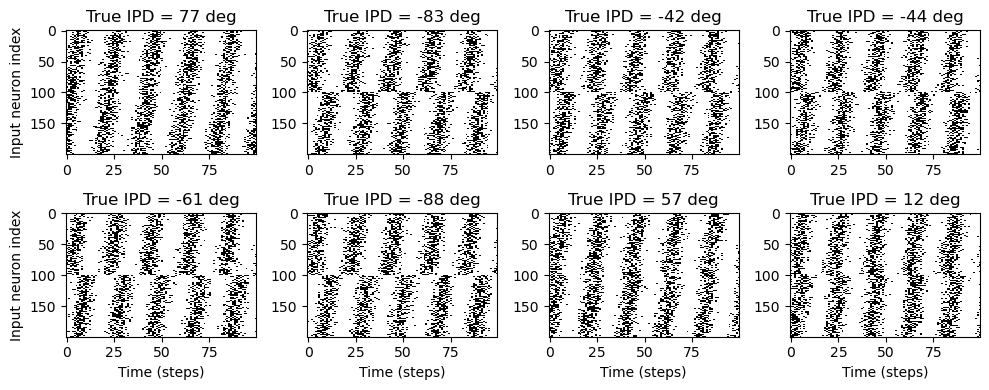

In [3]:
class ITDDataset(torch.utils.data.Dataset):
    def __init__(self,
                 num_samples,
                 dt=1*ms,             # large time step to make simulations run faster for tutorial
                 anf_per_ear=100,     # repeats of each ear with independent noise
                 envelope_power=2,    # higher values make sharper envelopes, easier
                 rate_max=600*Hz,     # maximum Poisson firing rate
                 f=stimulus_frequency,# stimulus frequency
                 duration=.1*second,  # stimulus duration
                 num_classes=default_num_classes, # number of IPD classes for discretisation
                 batch_size=128,
                 shuffle=True,
                 numpy_seed=32844534, # seed for numpy random number generator
                 ):
        self.num_samples = num_samples
        self.dt = dt
        self.anf_per_ear = anf_per_ear
        self.envelope_power = envelope_power
        self.rate_max = rate_max
        self.f = f
        self.duration = duration
        self.duration_steps = int(np.round(duration/dt))
        self.input_size = 2*anf_per_ear
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        if numpy_seed:
            np.random.seed(numpy_seed)
        self.ipd, self.spikes = self.random_ipd_input_signal()
        self.data_loader = torch.utils.data.DataLoader(self, batch_size=batch_size, shuffle=shuffle)

    # Generate an input signal (spike array) from array of true IPDs
    def input_signal(self, ipd, generate_spikes=True):
        num_samples = len(ipd)
        T = np.arange(self.duration_steps)*self.dt # array of times
        phi0 = np.random.rand()
        phi = 2*np.pi*(self.f*T+phi0) # array of phases corresponding to those times with random offset
        # each point in the array will have a different phase based on which ear it is
        # and its delay
        theta = np.zeros((num_samples, self.duration_steps, 2*self.anf_per_ear))
        # for each ear, we have anf_per_ear different phase delays from 0 to pi/2 so
        # that the differences between the two ears can cover the full range from -pi/2 to pi/2
        phase_delays = np.linspace(0, np.pi/2, self.anf_per_ear)
        # now we set up these theta to implement that. Some numpy vectorisation logic here which looks a little weird,
        # but implements the idea in the text above.
        theta[:, :, :self.anf_per_ear] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]
        theta[:, :, self.anf_per_ear:] = phi[np.newaxis, :, np.newaxis]+phase_delays[np.newaxis, np.newaxis, :]+ipd[:, np.newaxis, np.newaxis]
        # now generate Poisson spikes at the given firing rate as in the previous notebook
        if self.envelope_power==2:
            # exact integral solution for envelope power 2
            theta2 = theta + 2*np.pi*self.f*self.dt
            rate_integ = self.rate_max/4*((-np.sin(2*theta2) - 8*np.cos(theta2) + np.sin(2*theta) + 8*np.cos(theta) + 12*np.pi*self.f*self.dt)/(8*np.pi*self.f))
        else:
            rate_integ = self.rate_max*self.dt*(0.5*(1+np.sin(theta)))**self.envelope_power
        if generate_spikes:
            spikes = np.random.rand(num_samples, self.duration_steps, 2*self.anf_per_ear)<rate_integ
            return spikes
        else:
            return rate_integ

    # Generate some true IPDs from U(-pi/2, pi/2) and corresponding spike arrays
    def random_ipd_input_signal(self):
        ipd = np.random.rand(self.num_samples)*np.pi-np.pi/2 # uniformly random in (-pi/2, pi/2)
        spikes = self.input_signal(ipd)
        ipd = torch.tensor(ipd, device=device, dtype=dtype)        
        spikes = torch.tensor(spikes, device=device, dtype=dtype)
        return ipd, spikes
    
    def discretise(self, ipds):
        return ((ipds+np.pi/2)*self.num_classes/np.pi).long() # assumes input is tensor

    def continuise(self, ipd_indices): # convert indices back to IPD midpoints
        return (ipd_indices+0.5)/self.num_classes*np.pi-np.pi/2    
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.spikes[idx, :, :], self.discretise(self.ipd[idx])
    
    def visualise(self, w=4, h=2):
        N = w*h
        # Plot a few just to show how it looks
        spikes = self.spikes.cpu()
        plt.figure(figsize=(10, 4), dpi=100)
        for i in range(N):
            plt.subplot(h, w, i+1)
            plt.imshow(spikes[i, :, :].T, aspect='auto', interpolation='nearest', cmap=plt.cm.gray_r)
            plt.title(f'True IPD = {int(self.ipd[i]*180/np.pi)} deg')
            if i>=4:
                plt.xlabel('Time (steps)')
            if i%4==0:
                plt.ylabel('Input neuron index')
        plt.tight_layout()

if run_sample_data:
    train_data = ITDDataset(num_samples=128*128, batch_size=128)
    test_data = ITDDataset(num_samples=32*128, batch_size=128)
    test_data.visualise()

## Model

### Surrogate gradient function

In [4]:
class SurrGradSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        # Original SPyTorch/SuperSpike gradient
        # This seems to be a typo or error? But it works well
        #grad = grad_output/(100*torch.abs(input)+1.0)**2
        # Sigmoid
        beta = 5
        grad = grad_output*beta*torch.sigmoid(beta*input)*(1-torch.sigmoid(beta*input))
        return grad

spike_fn  = SurrGradSpike.apply

### Spiking neural network

In [5]:
class ITDNet(nn.Module):
    def __init__(self, dataset, num_hidden=default_num_hidden, tau=20*ms, dt=1*ms):
        super(ITDNet, self).__init__()
        self.input_size = dataset.input_size
        self.num_classes = dataset.num_classes
        self.num_hidden = num_hidden
        self.tau = tau
        self.dt = dt
        self.init_weight_matrices()

    # Weights and uniform weight initialisation
    def init_weight_matrices(self):
        # Input to hidden layer
        self.W_ih = nn.Parameter(torch.empty((self.input_size, self.num_hidden), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_ih)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.W_ih, -bound, bound)
        # Hidden layer to output
        self.W_ho = nn.Parameter(torch.empty((self.num_hidden, self.num_classes), device=device, dtype=dtype, requires_grad=True))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_ho)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.W_ho, -bound, bound)
        return self.W_ih, self.W_ho
        
    def forward(self, input_spikes, apply_softmax=True):
        batch_size, duration_steps, input_size = input_spikes.shape
        if input_size!=self.input_size:
            raise ValueError(f"Expected input size {self.input_size} but got {input_size}")
        # First layer: input to hidden
        v = torch.zeros((batch_size, self.num_hidden), device=device, dtype=dtype)
        s = torch.zeros((batch_size, self.num_hidden), device=device, dtype=dtype)
        s_rec = [s]
        h = torch.einsum("abc,cd->abd", (input_spikes, self.W_ih))
        alpha = np.exp(-self.dt/self.tau)
        for t in range(duration_steps - 1):
            new_v = (alpha*v + h[:, t, :])*(1-s) # multiply by 0 after a spike
            s = spike_fn(v-1) # threshold of 1
            v = new_v
            s_rec.append(s)
        s_rec = torch.stack(s_rec, dim=1)
        # Second layer: hidden to output
        v = torch.zeros((batch_size, self.num_classes), device=device, dtype=dtype)
        s = torch.zeros((batch_size, self.num_classes), device=device, dtype=dtype)
        v_rec = [v]
        h = torch.einsum("abc,cd->abd", (s_rec, self.W_ho))
        alpha = np.exp(-self.dt/self.tau)
        for t in range(duration_steps - 1):
            v = alpha*v + h[:, t, :]
            v_rec.append(v)
        v_rec = torch.stack(v_rec, dim=1)
        # Return softmax of mean recorded membrane potential of output
        m = torch.mean(v_rec, 1)  # Mean across time dimension
        if apply_softmax:
            log_softmax_fn = nn.LogSoftmax(dim=1)
            m = log_softmax_fn(m)
        return m, s_rec

    def train(self, nb_epochs=10, lr=0.01, fr_min=100*Hz, fr_max=200*Hz, pbar=None):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        loss_fn = nn.NLLLoss()
        # training loop
        loss_hist = []
        initial_nll_loss_target = -np.log(1/train_data.num_classes)
        if pbar is None:
            print(f"Want loss for epoch 1 to be about {initial_nll_loss_target:.2f}, multiply m by constant to get this")
            pbar = tqdm(total=nb_epochs)
            close_pbar = True
        else:
            close_pbar = False
        for e in range(nb_epochs):
            local_loss = []
            for spikes, ipds in train_data.data_loader:
                # Run network
                output, hidden_spikes = self(spikes)
                fr = torch.sum(hidden_spikes, dim=(0, 1))/(train_data.batch_size*train_data.duration) # tensor of length num_hidden
                reg_loss = torch.mean(initial_nll_loss_target*(torch.nn.functional.relu(fr-fr_min)/(fr_max-fr_min))**2)/self.num_hidden
                loss = loss_fn(output, ipds)+reg_loss
                local_loss.append(loss.item())
                # Update gradients
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            loss_hist.append(np.mean(local_loss))
            pbar.update(1)
            pbar.set_postfix(epoch=e, loss=loss_hist[-1])
        if close_pbar:
            pbar.close()
        return loss_hist

## Training

In [6]:
if run_sample_data:
    # net = ITDNet(train_data, tau=2*ms)
    #loss_hist = net.train(nb_epochs=10, lr=0.01) # quick training (a few minutes)
    #loss_hist = net.train(nb_epochs=100, lr=0.001) # long training for best results (about 30m)
    #torch.save(net, 'saved_trained_models/itdnet-for-paper.pt')
    net = torch.load('saved_trained_models/itdnet-for-paper.pt')
    # Plot the loss function over time
    # plt.plot(loss_hist)
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.tight_layout()

## Analysis of trained network

In [185]:
class AnalysisResults:
    def __init__(self, model, dataset, label, record_spikes=False):
        self.model = model
        self.dataset = dataset
        self.label = label
        self.record_spikes = record_spikes

        # compute results on test dataset
        all_output = []
        all_ipd_idx_true = []
        all_spikes = []
        all_hidden_fr = []
        for spikes, ipds in dataset.data_loader:
            with torch.no_grad():
                output, spikes_rec = model(spikes, apply_softmax=False)
                # spikes_rec has shape (batch_size, duration_steps, num_hidden)
            all_output.append(output)
            all_ipd_idx_true.append(ipds)
            all_hidden_fr.append(torch.sum(spikes_rec, dim=1)/self.dataset.duration)
            if record_spikes:
                for b in range(spikes_rec.shape[0]): # for each batch
                    time_idx, hidden_idx = torch.nonzero(spikes_rec[b, :, :]).detach().cpu().numpy().T
                    all_spikes.append((time_idx, hidden_idx))
        self.all_output = all_output = torch.cat(all_output, 0).detach().cpu().numpy()
        self.all_ipd_idx_est = all_ipd_idx_est = np.argmax(all_output, 1)
        self.all_ipd_idx_true = all_ipd_idx_true = torch.cat(all_ipd_idx_true, 0).detach().cpu().numpy()
        self.all_ipd_est = all_ipd_est = dataset.continuise(all_ipd_idx_est)
        self.all_ipd_true = all_ipd_true = dataset.continuise(all_ipd_idx_true)
        self.all_spikes= all_spikes
        self.all_hidden_fr = torch.cat(all_hidden_fr, 0).detach().cpu().numpy()

        # confusion matrix
        self.confusion = confusion = np.zeros((dataset.num_classes, dataset.num_classes))
        for i, j in zip(all_ipd_idx_true, all_ipd_idx_est):
            confusion[j, i] += 1
        confusion /= np.sum(confusion, axis=0)[np.newaxis, :]

        # tuning curves of output neurons
        def compute_tuning_curves(X): # X should have shape (num_samples, num_neurons)
            num_neurons = X.shape[1]
            tuning_curve_mean = np.zeros((dataset.num_classes, num_neurons))
            tuning_curve_std = np.zeros((dataset.num_classes, num_neurons))
            for i in range(dataset.num_classes):
                o = X[all_ipd_idx_true==i, :]
                tuning_curve_mean[i, :] = np.mean(o, axis=0)
                tuning_curve_std[i, :] = np.std(o, axis=0)
            return tuning_curve_mean, tuning_curve_std
        self.tuning_curves = {
            'output': compute_tuning_curves(all_output),
            'hidden': compute_tuning_curves(self.all_hidden_fr),
        }

        # accuracy
        self.accuracy = ((all_ipd_idx_est==all_ipd_idx_true)*1.0).mean()
        self.mean_abs_error_deg = np.mean(abs(all_ipd_true-all_ipd_est)*180/np.pi)

    def print_text(self):
        print(f"Accuracy on {self.label} set = {self.accuracy*100:.1f}%, mean absolute error = {self.mean_abs_error_deg:.1f} deg")
        return self

    def plot_histograms(self):
        plt.hist(self.all_ipd_true*180/np.pi, bins=self.dataset.num_classes, label='True', alpha=0.8)
        plt.hist(self.all_ipd_est*180/np.pi, bins=self.dataset.num_classes, label='Estimated', alpha=0.8)
        plt.xlabel("IPD")
        plt.yticks([])
        plt.legend(loc='best')
        plt.title(self.label)

    def plot_confusion(self):
        plt.imshow(self.confusion, interpolation='nearest', aspect='auto', origin='lower', extent=(-90, 90, -90, 90))
        plt.xlabel('True IPD')
        plt.ylabel('Estimated IPD')
        plt.title(f'Confusion matrix ({self.label})')

    def plot_tuning_curves(self, name='output', fig=None, c='k', label=None, normalise=False, reorder=None):
        tuning_curve_mean, tuning_curve_std = self.tuning_curves[name]
        if normalise:
            if normalise=='individual':
                mins = tuning_curve_mean.min(axis=0)[None, :]
                maxs = tuning_curve_mean.max(axis=0)[None, :]
            elif normalise=='population':
                mins = tuning_curve_mean.min()[None, None]
                maxs = tuning_curve_mean.max()[None, None]
            else:
                raise ValueError("normalise should be 'individual' or 'population'")
            tuning_curve_mean = (tuning_curve_mean-mins)/(maxs-mins)
            tuning_curve_std = tuning_curve_std/(maxs-mins)
            vertical_label = f'FR (norm={normalise})'
        else:
            mins = 0
            maxs = 1
            vertical_label = 'Firing rate (sp/s)'
        if label is None:
            label = self.label
        if fig is None:
            plt.figure(figsize=(12, 6), dpi=80)
        else:
            plt.figure(fig)
        num_neurons = tuning_curve_mean.shape[1]
        all_output = (self.all_output-mins)/(maxs-mins)
        for i in range(num_neurons):
            plt.subplot(3, 4, i+1)
            if reorder is not None:
                i = reorder[i]
            if name=='output':
                plt.plot(self.all_ipd_true*180/np.pi, all_output[:, i], ',', c='lightgray')
            plt.errorbar(self.dataset.continuise(np.arange(self.dataset.num_classes))*180/np.pi, tuning_curve_mean[:, i], tuning_curve_std[:, i]*1.96, c=c, label=label)
            if name=='output':
                plt.axvline(self.dataset.continuise(i)*180/np.pi, ls='--', c='r', label='True IPD')
            # if i//4==2:
            plt.xlabel('IPD (deg)')
            # if i%4==0:
            if name=='output':
                plt.ylabel(r'$\bar v$')
            else:
                plt.ylabel(vertical_label)
            plt.ylim((tuning_curve_mean-1.96*tuning_curve_std).min(), (tuning_curve_mean+1.96*tuning_curve_std).max())
        plt.suptitle(f"Tuning curves of {name} neurons")
        plt.tight_layout()

    def plot_weights(self, fig=None, reorder_by='ho'):
        W_ih = self.model.W_ih.detach().cpu().numpy()
        W_ho = self.model.W_ho.detach().cpu().numpy()
        W_io = W_ih @ W_ho

        if reorder_by=='ih':
            # for each column of W_ih, compute the weighted mean and re-order according to that
            A = np.arange(W_ih.shape[0]/2)
            A = np.concatenate((A, -A))
            A = A[:, None]
            weighted_mean = np.mean((A*W_ih), axis=0)
            # weighted_mean[np.max(np.abs(W_ih), axis=0)<.5] = np.inf
            I = np.argsort(weighted_mean)
            W_ih = W_ih[:, I]
            W_ho = W_ho[I, :]        
        elif reorder_by=='ho':
            # reorder by rows of W_ho
            A = np.arange(W_ho.shape[1])[None, :]
            weighted_mean = np.mean((A*W_ho), axis=1)
            I = np.argsort(-weighted_mean)
            W_ih = W_ih[:, I]
            W_ho = W_ho[I, :]

        def plot_matrix(W, x, y, t):
            plt.imshow(W, interpolation='nearest', aspect='auto', origin='lower', vmin=-np.abs(W).max(), vmax=np.abs(W).max(), cmap='RdBu')
            plt.ylabel(y)
            plt.xlabel(x)
            plt.title(t)
            plt.colorbar(label="Weight")

        if fig is None:
            plt.figure(figsize=(10, 3), dpi=100)
        else:
            plt.figure(fig)
        plt.subplot(131)
        plot_matrix(W_ih, 'Hidden layer neuron index', 'Input neuron index', r'$W_{ih}$'+(' (reordered)' if reorder_by else ''))
        plt.subplot(132)
        plot_matrix(W_ho, 'Output neuron index', 'Hidden layer neuron index', r'$W_{ho}$'+(' (reordered)' if reorder_by else ''))
        plt.subplot(133)
        plot_matrix(W_io, 'Output neuron index', 'Input neuron index', r'$W_{io} = W_{ih} \cdot W_{ho} $')
        plt.tight_layout()

    def plot_hidden_firing_rates(self):
        plt.figure(figsize=(8, 4), dpi=100)
        plt.bar(np.arange(self.model.num_hidden), self.all_hidden_fr.mean(axis=0))
        plt.xlabel('Hidden neuron index')
        plt.ylabel('Firing rate (Hz)')
        plt.title('Hidden neuron firing rates')
        plt.tight_layout()

    def plot_rasters(self):
        plt.figure(figsize=(10, 4), dpi=100)
        for i in range(8):
            plt.subplot(2, 4, i+1)
            time_idx, hidden_idx = self.all_spikes[i]
            plt.plot(time_idx*self.dataset.dt, hidden_idx, '.k', markersize=1)
            plt.ylim(-1, self.model.num_hidden)
            plt.xlim(0, self.dataset.duration)
            plt.title(f'True IPD = {int(self.all_ipd_true[i]*180/np.pi)} deg')
            if i>=4:
                plt.xlabel('Time (steps)')
            if i%4==0:
                plt.ylabel('Hidden neuron index')
        plt.tight_layout()

    def visualise(self):
        plt.figure(figsize=(10, 4), dpi=100)
        plt.subplot(121)
        self.plot_histograms()
        plt.subplot(122)
        self.plot_confusion()
        plt.tight_layout()    
        self.plot_hidden_firing_rates()
        if self.record_spikes:
            self.plot_rasters()
        self.plot_tuning_curves('output')
        self.plot_tuning_curves('hidden')
        self.plot_weights() 
        return self

Chance accuracy level: 8.3%
Accuracy on Test set = 82.6%, mean absolute error = 2.6 deg


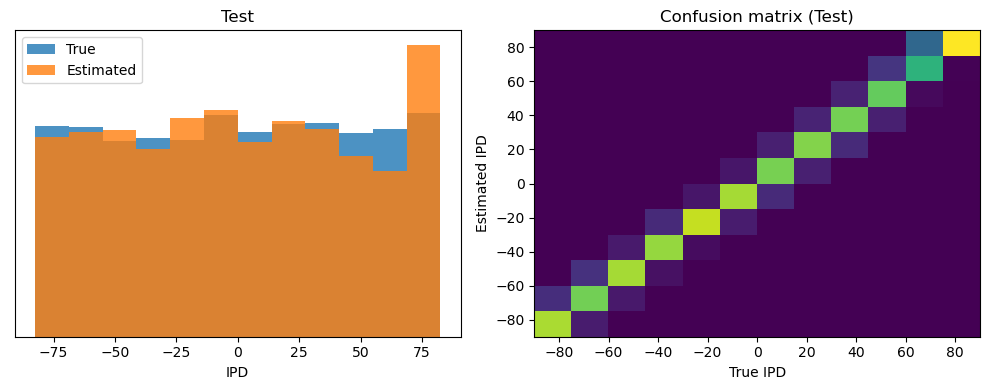

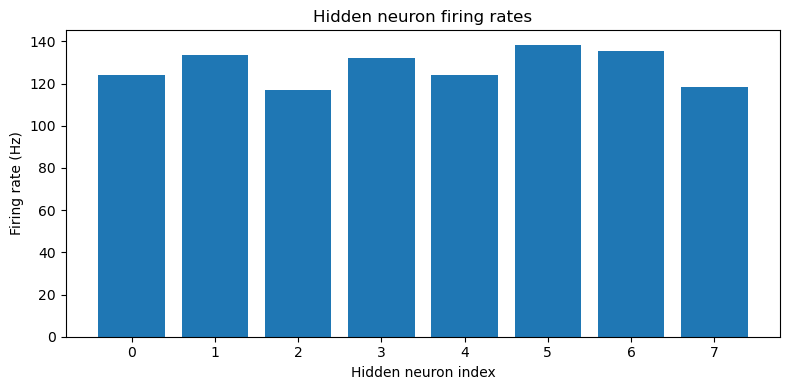

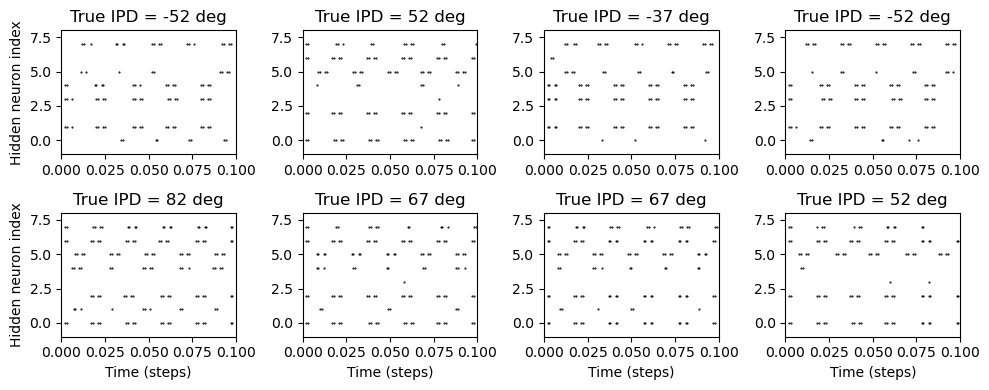

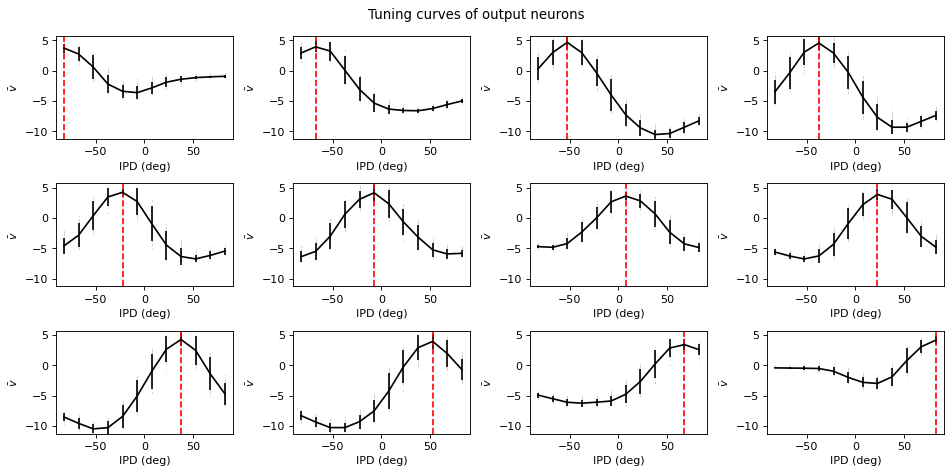

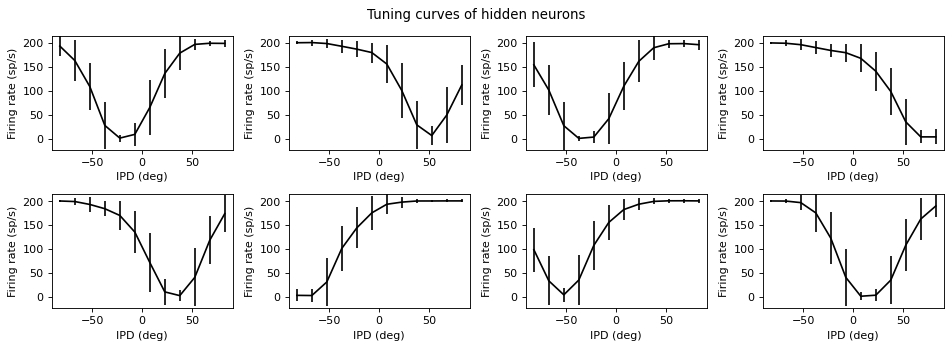

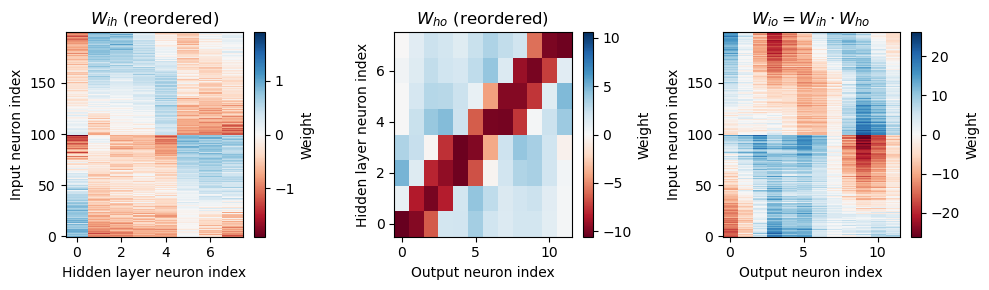

In [186]:
if run_sample_data:
    print(f"Chance accuracy level: {100/train_data.num_classes:.1f}%")
    # results_train = AnalysisResults(net, train_data, 'Train').print_text()
    results_test = AnalysisResults(net, test_data, 'Test', record_spikes=True).print_text().visualise()

## Understanding the solution found

### Reorder matrices

Throughout this section we want the hidden units in order of their selectivity.

In [55]:
W_ih = net.W_ih.detach().cpu().numpy()
W_ho = net.W_ho.detach().cpu().numpy()
W_io = W_ih @ W_ho

# reorder by rows of W_ho
A = np.arange(W_ho.shape[1])[None, :]
weighted_mean = np.mean((A*W_ho), axis=1)
I_reorder = np.argsort(-weighted_mean)
W_ih = W_ih[:, I_reorder]
W_ho = W_ho[I_reorder, :]

### Fitting the hidden-to-output matrix to a simple function

The cell below shows the hidden->output matrix if the number of hidden neurons was the same as the number of output, and it was shifted. It shows that more or less the hidden->output matrix is just a sort of inverted Gaussian or maybe mexican hat around a moving centre.

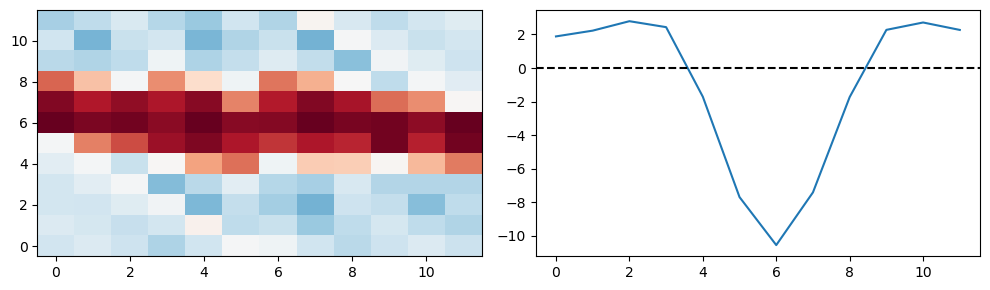

In [51]:
W_ho_interp = torch.nn.functional.interpolate(torch.tensor(W_ho).reshape(1,1,8,12), size=(12, 12), mode='bicubic').detach().numpy()[0, 0, :, :]
I, J = np.meshgrid(np.arange(12), np.arange(12))
J = (I+J+6)%12
W_ho_interp = W_ho_interp[I, J]
plt.figure(figsize=(10, 3), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(W_ho_interp, interpolation='nearest', aspect='auto', origin='lower', vmin=-np.abs(W_ho).max(), vmax=np.abs(W_ho).max(), cmap='RdBu');
plt.subplot(1, 2, 2)
plt.plot(W_ho_interp.mean(axis=1))
plt.axhline(0, ls='--', c='k')
plt.tight_layout();

Let's try to directly fit that with a Ricker ("mexican hat" function). It works well!

[-9.36703502 -0.77569935 -2.22641301]


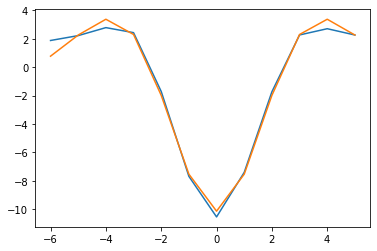

In [52]:
from scipy.optimize import curve_fit
psi = lambda t, a, b, sigma: a*(1-(t/sigma)**2)*np.exp(-t**2/(2*sigma**2))+b
t = np.arange(12)-6
y = W_ho_interp.mean(axis=1)
popt, pcov = curve_fit(psi, t, y, p0=[1, 0, 1])
print(popt)
plt.plot(t, y)
plt.plot(t, psi(t, *popt))

And now we fit the whole matrix with the same approach, looks good enough to try in the rate-based model.

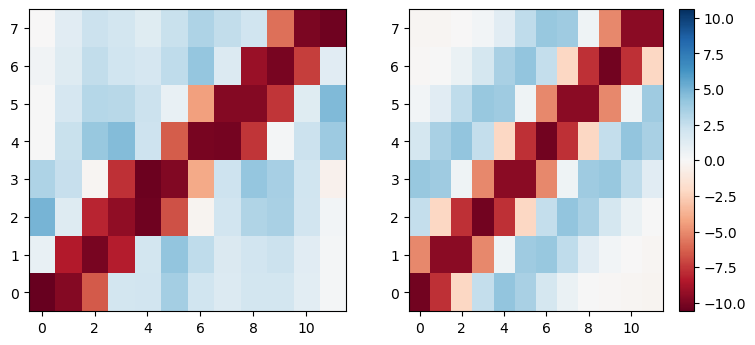

In [53]:
psi = lambda t, a, b, sigma: a*(1-(t/sigma)**2)*np.exp(-t**2/(2*sigma**2))+b
H, O = np.meshgrid(np.arange(W_ho.shape[1]), np.arange(W_ho.shape[0]))
t = (O-W_ho.shape[0]*(H*1.0)/W_ho.shape[1]).flatten()
W_ho_flat = W_ho.flatten()
popt, pcov = curve_fit(psi, t, W_ho_flat, p0=[1, 0, 1])
W_ho_fit = psi(t, *popt).reshape(W_ho.shape)

plt.figure(figsize=(9, 4), dpi=100)
plt.subplot(1, 2, 1)
plt.imshow(W_ho, interpolation='nearest', aspect='auto', origin='lower', vmin=-np.abs(W_ho).max(), vmax=np.abs(W_ho).max(), cmap='RdBu')
plt.subplot(1, 2, 2)
plt.imshow(W_ho_fit.reshape(W_ho.shape), interpolation='nearest', aspect='auto', origin='lower', vmin=-np.abs(W_ho).max(), vmax=np.abs(W_ho).max(), cmap='RdBu')
plt.colorbar()

### Fitting hidden neuron tuning curves to Gaussians

Fairly good fit.

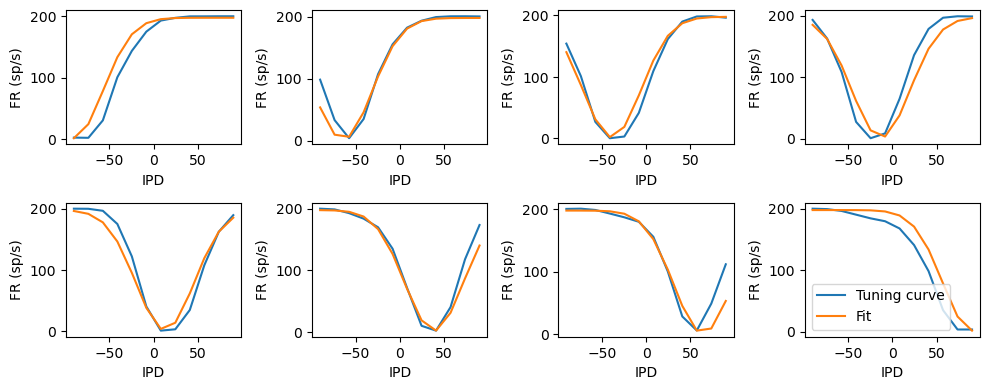

In [156]:
tuning_curve_mean, _ = results_test.tuning_curves['hidden'] # (num_classes, num_neurons)
tuning_curve_mean = tuning_curve_mean[:, I_reorder]
ipds = np.linspace(-np.pi/2, np.pi/2, test_data.num_classes)
IPD, H = np.meshgrid(ipds, np.arange(net.num_hidden), indexing='ij')
t = -np.pi/2+H*np.pi/(net.num_hidden-1)-IPD
psi = lambda t, a, b, sigma: a*np.exp(-t**2/(2*sigma**2))+b
popt, pcov = curve_fit(psi, t.flatten(), tuning_curve_mean.flatten(), p0=[-200, 200, 1])
tuning_curve_fit = psi(t, *popt)
plt.figure(figsize=(10, 4), dpi=100)
for i in range(net.num_hidden):
    plt.subplot(2, 4, i+1)
    plt.plot(ipds*180/np.pi, tuning_curve_mean[:, i], label='Tuning curve')
    plt.plot(ipds*180/np.pi, tuning_curve_fit[:, i], label='Fit')
    plt.xlabel('IPD')
    plt.ylabel('FR (sp/s)')
plt.legend(loc='best')
plt.tight_layout();

### Predicting output curves based on rate-based model

The idea of the cell below is to compute the mean output of each stage assuming no spiking. The fit is fairly good, suggesting that it's not really using the spiking at all.

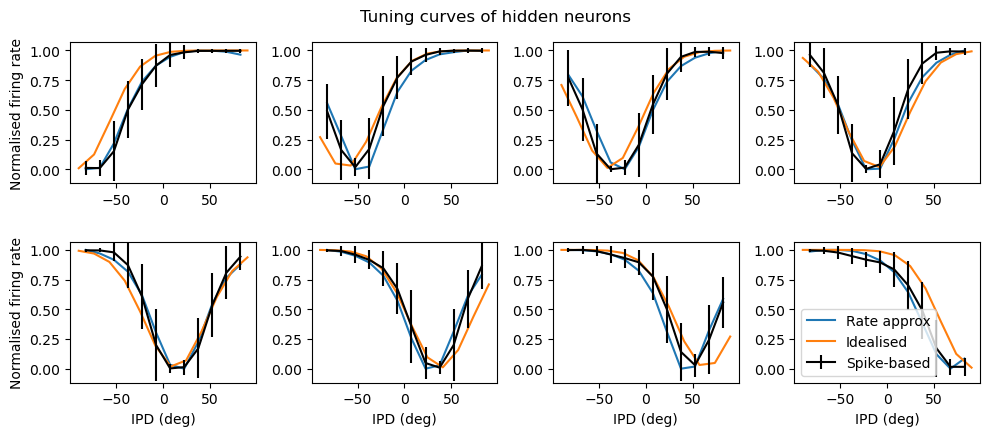

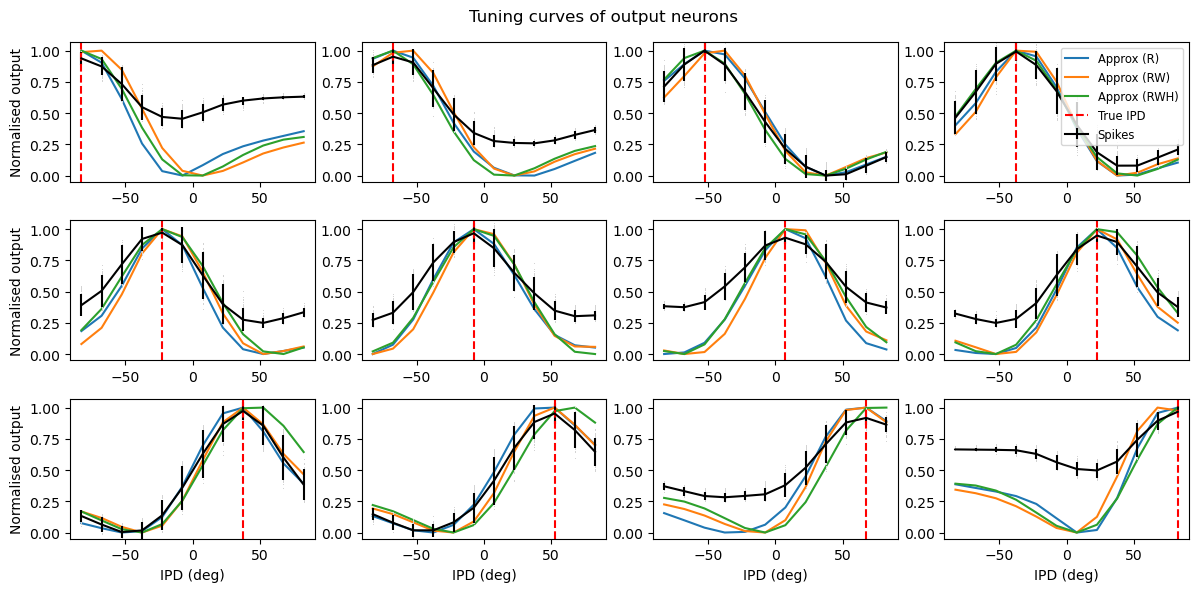

In [187]:
# Applying kernel makes no difference
# kernel_t = np.arange(-test_data.duration_steps+1, test_data.duration_steps)*test_data.dt
# kernel = (kernel_t>=0)*np.exp(-kernel_t/net.tau)
# plt.figure()
# plt.plot(kernel_t, kernel)

ipds = np.linspace(-np.pi/2, np.pi/2, test_data.num_classes)
rates_input = test_data.input_signal(ipds, generate_spikes=False)
# rates_hidden = np.clip(np.einsum('ih,cti->cth', W_ih, rates_input), 0, np.inf)
sigmoid = lambda x: 1/(1+np.exp(-.4*x))
rates_hidden = sigmoid(np.einsum('ih,cti->cth', W_ih, rates_input))
# rates_hidden = np.einsum('ih,cti->cth', W_ih, rates_input) # this doesn't work well at all
# Applying kernel unnecessary for a good fit
# for c in range(rates_hidden.shape[0]):
#     for h in range(rates_hidden.shape[2]):
#         rates_hidden[c, :, h] = np.convolve(rates_hidden[c, :, h], kernel, mode='valid')
rates_output = np.einsum('ho,cth->cto', W_ho, rates_hidden)
rates_output_ricker = np.einsum('ho,cth->cto', W_ho_fit, rates_hidden)
rates_output_ricker_and_ideal = np.einsum('ho,ch->co', W_ho_fit, tuning_curve_fit)[:, None, :]
# Adding sigmoid here doesn't help which makes sense because these neurons are non-spiking
# sigmoid = lambda x: 1/(1+np.exp(-.1*x))
# rates_output = sigmoid(np.einsum('ho,cth->cto', W_ho, rates_hidden))
# rates_output_ricker = sigmoid(np.einsum('ho,cth->cto', W_ho_fit, rates_hidden))
# rates_input.shape # (num_classes, duration_steps, 2*anf_per_ear)

# plt.figure(figsize=(12, 6), dpi=100)
# for i in range(12):
#     plt.subplot(3, 4, i+1)
#     plt.imshow(rates_input[i, :, :].T, aspect='auto', interpolation='nearest', origin='lower', vmin=0)
# plt.suptitle('Mean input rates')
# plt.tight_layout()

# plt.figure(figsize=(12, 4), dpi=100)
# for i in range(8):
#     plt.subplot(2, 4, i+1)
#     plt.imshow(rates_hidden[i, :, :].T, aspect='auto', interpolation='nearest', origin='lower', vmin=0)
# plt.suptitle('Mean hidden rates')
# plt.tight_layout()

# plt.figure(figsize=(12, 6), dpi=100)
# for i in range(12):
#     plt.subplot(3, 4, i+1)
#     plt.imshow(rates_output[i, :, :].T, aspect='auto', interpolation='nearest', origin='lower', vmin=-np.abs(rates_output).max(), vmax=np.abs(rates_output).max(), cmap='RdBu')
# plt.suptitle('Mean output rates')
# plt.tight_layout()

# tuning curve comparison

fig = plt.figure(figsize=(10, 6), dpi=100)
for i in range(net.num_hidden):
    plt.subplot(3, 4, i+1)
    tc = rates_hidden[:, :, i].mean(axis=1)
    tc = (tc-tc.min())/(tc.max()-tc.min())
    plt.plot(results_test.dataset.continuise(np.arange(results_test.dataset.num_classes))*180/np.pi, tc, label='Rate approx')
    plt.plot(ipds*180/np.pi, tuning_curve_fit[:, i]/np.max(tuning_curve_fit), label='Idealised')
results_test.plot_tuning_curves('hidden', normalise='population', label='Spike-based', reorder=I_reorder, fig=fig)
plt.legend(loc='best')
for i in range(4):
    plt.subplot(3, 4, i+1)
    plt.xlabel('')
for i in [1, 2, 3, 5, 6, 7]:
    plt.subplot(3, 4, i+1)
    plt.ylabel('')
for i in [0, 4]:
    plt.subplot(3, 4, i+1)
    plt.ylabel('Normalised firing rate')
plt.tight_layout()

fig = plt.figure(figsize=(12, 6), dpi=100)
for i in range(12):
    plt.subplot(3, 4, i+1)
    tc = rates_output[:, :, i].mean(axis=1)
    tc = (tc-tc.min())/(tc.max()-tc.min())
    plt.plot(results_test.dataset.continuise(np.arange(results_test.dataset.num_classes))*180/np.pi, tc, label='Approx (R)')
    tc = rates_output_ricker[:, :, i].mean(axis=1)
    tc = (tc-tc.min())/(tc.max()-tc.min())
    plt.plot(results_test.dataset.continuise(np.arange(results_test.dataset.num_classes))*180/np.pi, tc, label='Approx (RW)')
    tc = rates_output_ricker_and_ideal[:, :, i].mean(axis=1)
    tc = (tc-tc.min())/(tc.max()-tc.min())
    plt.plot(results_test.dataset.continuise(np.arange(results_test.dataset.num_classes))*180/np.pi, tc, label='Approx (RWH)')
results_test.plot_tuning_curves('output', normalise='population', fig=fig, label='Spikes')
plt.subplot(3, 4, 4)
plt.legend(loc='best', fontsize='small')
for i in range(8):
    plt.subplot(3, 4, i+1)
    plt.xlabel('')
for i in [1, 2, 3, 5, 6, 7, 9, 10, 11]:
    plt.subplot(3, 4, i+1)
    plt.ylabel('')
for i in [0, 4, 8]:
    plt.subplot(3, 4, i+1)
    plt.ylabel('Normalised output')
plt.tight_layout();

### Understanding hidden unit tuning curve shape

Not clear there's much to be got from this, it's just a very overcomplete basis set.

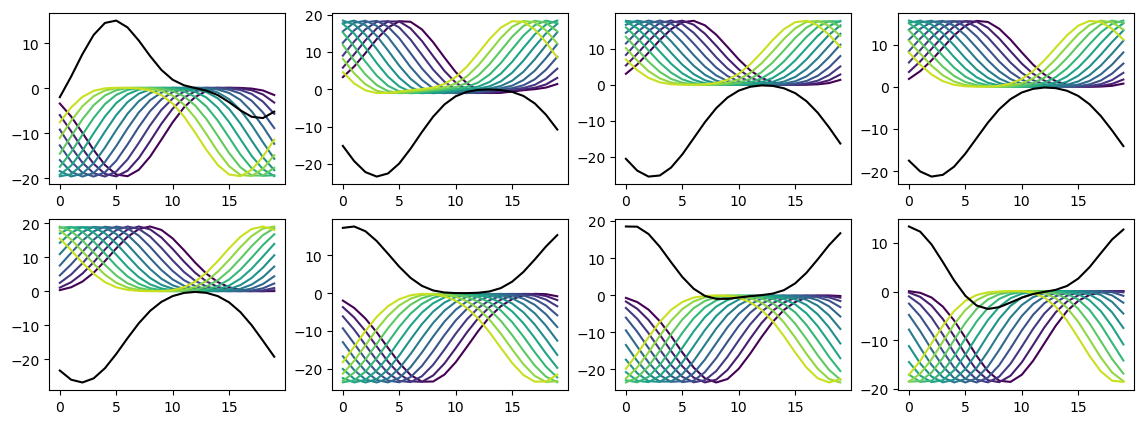

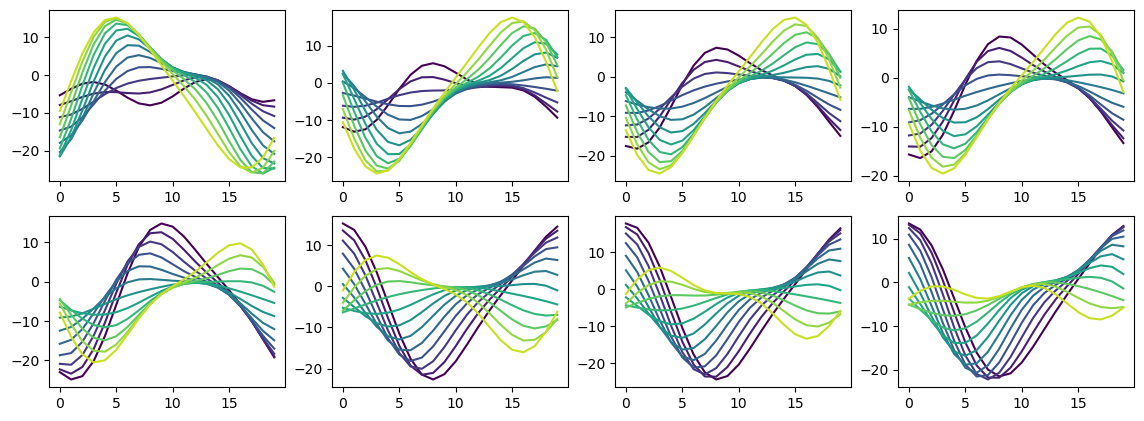

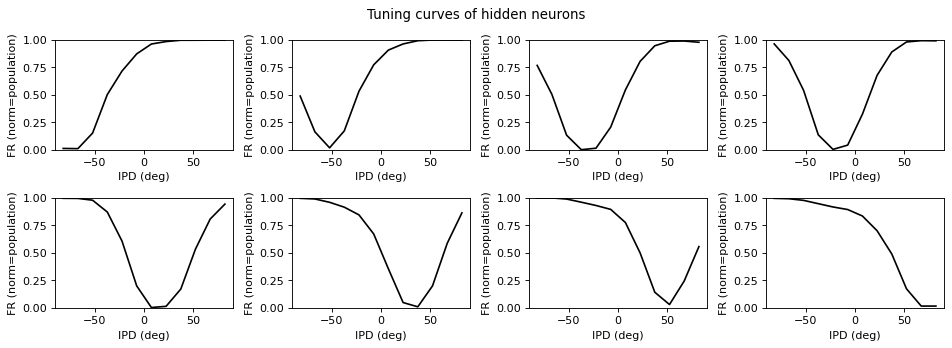

In [157]:
single_phase_steps = int(1/(test_data.f*test_data.dt))
rates_hidden_L = np.einsum('ih,cti->cth', W_ih[:test_data.anf_per_ear, :], rates_input[:,:single_phase_steps,:test_data.anf_per_ear])
rates_hidden_R = np.einsum('ih,cti->cth', W_ih[test_data.anf_per_ear:, :], rates_input[:,:single_phase_steps,test_data.anf_per_ear:])
plt.figure(figsize=(14, 5), dpi=100)
for j in range(8):
    plt.subplot(2, 4, j+1)
    for i in range(test_data.num_classes):
        plt.plot(rates_hidden_R[i, :, j], '-', c=plt.cm.viridis(i/test_data.num_classes))
        # plt.plot(rates_hidden_L[0, :, j], '-', c=plt.cm.autumn(i/test_data.num_classes))
    plt.plot(rates_hidden_L[0, :, j], '-k')
plt.figure(figsize=(14, 5), dpi=100)
for j in range(8):
    plt.subplot(2, 4, j+1)
    for i in range(test_data.num_classes):
        # sigmoid = lambda x: 1/(1+np.exp(-0.3*x))
        sigmoid = lambda x: x
        plt.plot(sigmoid(rates_hidden_L[i, :, j]+rates_hidden_R[i, :, j]), '-', c=plt.cm.viridis(i/test_data.num_classes))
results_test.plot_tuning_curves('hidden', normalise='population', reorder=I_reorder)

## Varying $\tau$

Below we systematically vary the membrane time constant $\tau$, saving results as we go, and then analyse the solutions found.


### Run the simulations or load the saved data if available

In [11]:
if run_sweep:
    # # Quick run settings for debugging
    # tau_range = [2, 20]
    # nb_epochs = 10
    # num_hidden = 30
    # Long run settings for detailed analysis
    tau_range = [1, 2, 5, 10, 15, 20, 25, 30]
    nb_epochs = 10 # actually seems to just start overfitting after 10 epochs
    num_hidden = 30
    # Common
    num_classes = train_data.num_classes
    # Run the simulations or load the data if saved
    if not os.path.exists('tempdata'):
        os.mkdir('tempdata')
    pbar_steps = nb_epochs*len(tau_range)
    nets = {}
    results = {}
    with tqdm(total=(nb_epochs+2)*len(tau_range)) as pbar:
        for tau in tau_range:
            fname = f'tempdata/itdnet_tau_{tau}_epochs_{nb_epochs}_hidden_{num_hidden}_classes_{num_classes}'
            if os.path.exists(fname+'.pt'):
                net = torch.load(fname+'.pt')
                loss_hist = np.load(fname+'_loss.npy')
                plt.plot(loss_hist, label=f'$\\{tau=}$ ms')
                pbar.update(nb_epochs)
                pbar.set_postfix(loaded=f'{tau=} ms')
            else:
                net = ITDNet(train_data, num_hidden=num_hidden, tau=tau*ms)
                loss_hist = np.array(net.train(nb_epochs=nb_epochs, pbar=pbar))
                np.save(fname+'_loss.npy', loss_hist)
                torch.save(net, fname+'.pt')
                # Plot the loss function over time
                plt.plot(loss_hist, label=f'$\\{tau=}$ ms')
            if os.path.exists(fname+'_results.pickle'):
                with open(fname+'_results.pickle', 'rb') as f:
                    results_train, results_test = pickle.load(f)
                pbar.update(2)
                pbar.set_postfix(loaded_results=f'{tau=} ms')
            else:
                results_train = AnalysisResults(net, train_data, 'Train')
                pbar.update(1)
                pbar.set_postfix(results='train')
                results_test = AnalysisResults(net, test_data, 'Test')
                pbar.update(1)
                pbar.set_postfix(results='test')
                with open(fname+'_results.pickle', 'wb') as f:
                    pickle.dump((results_train, results_test), f)
            results[tau, 'train'] = results_train
            results[tau, 'test'] = results_test
            print(f'{tau=} ms')
            results_train.print_text()
            results_test.print_text()
            nets[tau] = net
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.tight_layout()

### Analyse the results

In [12]:
if run_sweep:
    plt.figure(figsize=(8, 3), dpi=80)
    plt.subplot(121)
    for l in ['test', 'train']:
        plt.plot(tau_range, [100*results[tau, l].accuracy for tau in tau_range], label=l)
    plt.legend(loc='best')
    plt.xlabel(r'$\tau$ (ms)')
    plt.ylabel('Accuracy (%)')
    plt.ylim(0, 100)
    plt.subplot(122)
    for l in ['test', 'train']:
        plt.plot(tau_range, [results[tau, l].mean_abs_error_deg for tau in tau_range], label=l)
    plt.xlabel(r'$\tau$ (ms)')
    plt.ylabel('Mean absolute error (deg)')
    plt.ylim(ymin=0)
    plt.tight_layout()

    fig = plt.figure(figsize=(12, 6), dpi=80)
    for i, tau in enumerate(tau_range):
        c = i/(len(tau_range)-1)
        c = (c, c/2, 1-c)
        results[tau, 'test'].plot_tuning_curves(fig=fig, c=c, label=f'$\\{tau=}$ ms')
    plt.legend(loc='best')

    for tau in tau_range:
        results[tau, 'test'].plot_weights()
        plt.suptitle(f'$\\{tau=}$ ms')
        plt.tight_layout()